In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
from scipy.linalg import sqrtm
import seaborn as sns

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

In [5]:
import os

In [6]:
os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"

In [7]:
latexify(width_scale_factor=2.5, fig_height=1.5)

saving image to figures/natgrad_descent_vectors_orig_latexified.pdf
Figure size: [2.4 1.5]


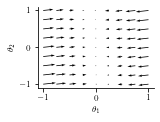

saving image to figures/natgrad_descent_vectors_natural_latexified.pdf
Figure size: [2.4 1.5]


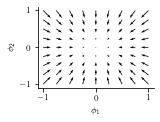

In [11]:
def L_dL_G(theta, X, sf):
    KL = (
        1 / 2 * (X[0, :] - (sf * theta[0] + 1 / sf * theta[1])) ** 2
        + 1 / 2 * (X[1, :] - (1 / sf * theta[0])) ** 2
        - 1 / 2 * X[0, :] ** 2
        - 1 / 2 * X[1, :] ** 2
    )
    L = np.mean(KL)

    dlpdtheta = -np.array(
        [
            sf * (X[0, :] - (sf * theta[0] + 1 / sf * theta[1])) + 1 / sf * (X[1, :] - (1 / sf * theta[0])),
            1 / sf * (X[0, :] - (sf * theta[0] + 1 / sf * theta[1])),
        ]
    )
    dL = np.mean(dlpdtheta, axis=1)
    G = np.array([[sf**2 + 1 / (sf**2), 1], [1, 1 / (sf**2)]])
    return L, dL, G


def make_vector_field_plots():
    # initialize the theta domain
    theta1, theta2 = np.meshgrid(np.linspace(-1, 1, 9), np.linspace(-1, 1, 9))
    theta = np.array([theta1.T.flatten(), theta2.T.flatten()])
    sf = 3

    # get random values and subtract their mean
    X = np.random.randn(2, 10000)
    X = X - np.mean(X, axis=1).reshape(2, 1)
    dL = np.zeros_like(theta)
    for i in range(0, theta.shape[1]):
        _, dL[:, i], G = L_dL_G(theta[:, i], X, sf)

    # change derivative to get steepest descent
    dL = -dL
    plt.figure()
    plt.quiver(theta[0, :], theta[1, :], dL[0, :], dL[1, :])
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    # plt.title("Steepest descent vectors in \noriginal parameter space")
    sns.despine()
    plt.gca().set_aspect(0.7)
    # savefig("SDOriginalParam")
    savefig("natgrad_descent_vectors_orig")
    plt.savefig("natgrad_descent_vectors_orig_latexified.png", dpi=500)
    plt.show()

    phi = theta.copy()
    theta = np.linalg.inv(sqrtm(G)).dot(phi)
    dL = np.zeros_like(theta)
    for i in range(0, theta.shape[1]):
        _, dL[:, i], G = L_dL_G(theta[:, i], X, sf)
    dL = -dL

    dLphi = sqrtm(np.linalg.inv(G)).dot(dL)
    plt.figure()
    plt.quiver(phi[0, :], phi[1, :], dLphi[0, :], dLphi[1, :])
    plt.xlabel(r"$\phi_1$")
    plt.ylabel(r"$\phi_2$")
    # plt.title("Steepest descent vectors in \nnatural parameter space")
    sns.despine()
    plt.gca().set_aspect(0.7)
    # savefig("SDNaturalParam")
    savefig("natgrad_descent_vectors_natural")
    plt.savefig("natgrad_descent_vectors_natural_latexified.png", dpi=500)
    plt.show()


make_vector_field_plots()

In [ ]:
def make_convergence_plots():
    X = np.random.randn(2, 1000)
    X = X - np.mean(X, axis=1).reshape(2, 1)

    theta_init = np.array([[1], [-1]])
    sf = 3
    # Setting number of update steps
    # theta_trajectory_steepest = theta_init.dot(np.ones((1, 1000)))
    theta_trajectory_steepest = theta_init.dot(np.ones((1, 100000)))
    theta_trajectory_natural = theta_trajectory_steepest.copy()
    L_trajectory_steepest = np.zeros((1, theta_trajectory_steepest.shape[1] - 1))
    L_trajectory_natural = np.zeros_like(L_trajectory_steepest)

    eps_steep = 1 / (sf**2) / 5
    eps_nat = eps_steep * sf**2

    for i in range(1, theta_trajectory_steepest.shape[1]):
        L, dL, G = L_dL_G(theta_trajectory_steepest[:, i - 1], X, sf)
        L_trajectory_steepest[:, i - 1] = L
        theta_trajectory_steepest[:, i] = theta_trajectory_steepest[:, i - 1] - eps_steep * dL
        L, dL, G = L_dL_G(theta_trajectory_natural[:, i - 1], X, sf)
        L_trajectory_natural[:, i - 1] = L
        theta_trajectory_natural[:, i] = theta_trajectory_natural[:, i - 1] - eps_nat * (np.linalg.lstsq(G, dL)[0])

    plt.figure()
    plt.plot(
        theta_trajectory_steepest[0, :].T,
        theta_trajectory_steepest[1, :].T,
        "+r",
        markersize=5,
        label="Steepest descent",
    )
    plt.plot(theta_trajectory_natural[0, :].T, theta_trajectory_natural[1, :].T, "xb", markersize=5, label="NG descent")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.title("Parameter trajectories")
    plt.legend(loc="upper right", markerfirst=False, frameon=False, fontsize=7)
    sns.despine()
    savefig("DescentPathsSteepestNGDescent")
    # savefig("natgrad_descent_params")
    plt.savefig("natgrad_descent_params_latexified.png", dpi=500)
    plt.show()

    plt.figure()
    plt.loglog(L_trajectory_steepest.flatten(), "+r", markersize=5, label="Steepest descent")
    plt.loglog(L_trajectory_natural.flatten(), "xb", markersize=5, label="Natural gradient descent")
    plt.xlabel("Number of update steps")
    plt.ylabel("KL divergence")
    plt.title("KL divergence vs. update step")
    sns.despine()
    savefig("KLDivergenceSteepestNGDescent")
    # savefig("natgrad_descent_kl")
    plt.savefig("natgrad_descent_kl_latexified.png", dpi=500)
    plt.show()


make_convergence_plots()

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
